In [89]:
import hashlib
import os
import tarfile
import zipfile
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [51]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [52]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import TensorDataset,DataLoader

In [54]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [55]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [56]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [57]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:-1]))

In [58]:
# 标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [59]:
# 补全缺失值（因为标准化之后，均值=0，所以直接将缺失值记为0）
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [60]:
# 独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [61]:
n_train = train_data.shape[0]
# 训练数据的X
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# 训练数据的Y
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
# 测试数据的X
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

# 训练

In [81]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

331


In [99]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(MLP, self).__init__()
        self.relu = nn.ReLU()
        self.hidden_1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.output = nn.Linear(hidden_size_3, output_size)
    def forward(self, x):
        x = self.hidden_1(x)
        x = self.relu(x)
#         x = self.hidden_2(x)
#         x = self.relu(x)
#         x = self.hidden_3(x)
#         x = self.relu(x)
        x = self.output(x)
        return x

In [93]:
# 这个数据可以表征预测和真实的相对差距
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    features = features.to(device)
    labels = labels.to(device)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [90]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_dataset = TensorDataset(train_features, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证

In [66]:
# 每次在k-1个子集上进行训练， 并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice为切片操作
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        # 如果就是第i组，这组数据设置为验证集
        if(j == i):
            X_valid, y_valid = X_part, y_part
        # 如果不是第i组，且训练集为空，让训练集等于这组数据
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 如果不是第i组，且训练集不空，沿着第0维度拼接训练集
        else:
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid
        

In [97]:
input_size = in_features
hidden_size_1 = 1
hidden_size_2 = 1
hidden_size_3 = 1
output_size = 1

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data =  get_k_fold_data(k, i, X_train, y_train)
        net = MLP(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
        net.to(device)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse2.902282, 验证log rmse2.913252
折2，训练log rmse0.121111, 验证log rmse0.210486
折3，训练log rmse0.136007, 验证log rmse0.209931
折4，训练log rmse0.134172, 验证log rmse0.178018
折5，训练log rmse0.114420, 验证log rmse0.170487
5-折验证: 平均训练log rmse: 0.681598, 平均验证log rmse: 0.736435


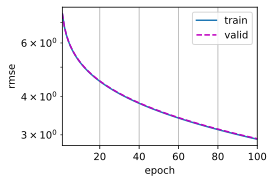

In [100]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')